* This notebook was made to check the difference between short vs long river in the salinity and currents field in the hourly results. This work is motivated by the high value of min salinity in 3.6 with long river(TS4) vs TS2, which we speculate it may be either caused by intense vertical mixing or relatively low river flow at the mouth with long river (mass conservation). However, I don't quite believe that results and think if it is mainly caused by low river flow at the mouth, it seems to contradict with the baseline we have stronger currents field with long river even taken into account the tidal currents. What if that 3.6 daily results did not count in the tidal part as it resolves the tidal component. Here, in 3.4, with hourly results, I want to examine the same issue with short and long river and see if this makes diffrence.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import (viz_tools,tidetools,nc_tools)
import seaborn as sns
import matplotlib.gridspec as gridspec
import os
sns.set_style('darkgrid')

In [2]:
grid6 =nc.Dataset(
        '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc',
        'r')
grid2 =nc.Dataset(
        '/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc',
        'r')
grids = [grid2,grid6]
Bathy = grid6.variables['Bathymetry'][:, :]
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]

In [3]:
runs=['oct8_10nowcast','oct8_10RFdailySmoo']
base='/data/jieliu/MEOPAR/river-treatment'
depths={};sals={}; ssh = {};Us={}; Vs={}
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    ssh[run] = f.variables['sossheig']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']
    timesteps = f.variables['time_counter']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']
## for time t
path = os.path.join(base,'{}/SalishSea_1h_20141008_20141010_grid_T.nc'.format(runs[0]))
f = nc.Dataset(path,'r');
t_t = nc_tools.timestamp(f, np.arange(len(timesteps)))
for ind in range(len(t_t)):
    t_t[ind] = t_t[ind].datetime
tt = np.array(t_t)   

In [4]:
def quiver_salinity(t,dep,imin=1,imax=396,jmin=1,jmax=896,st=5,cmin= -4, cmax=4, dels = 0.4):
    "compare rivers and salinity at t, dep in box. st is quiver arrow interval"
    fig,axs = plt.subplots(1,3,figsize=(36,15))
    x=np.arange(imin,imax)
    y=np.arange(jmin,jmax)
    U={}; V={};u={};v={};uE={};vN={};
    for key, ax,grid in zip(runs,axs[:-1],grids):
        #truncate U/V and unstagger
        U[key]= Us[key][t,dep,jmin-1:jmax,imin-1:imax]
        V[key] =Vs[key][t,dep,jmin-1:jmax,imin-1:imax]
        lon=T_lon[jmin:jmax,imin:imax]
        lat=T_lat[jmin:jmax,imin:imax]
        S=sals[key][t,dep,jmin:jmax,imin:imax]
        S = np.ma.masked_values(S, 0)
        #masking
        U[key] = np.ma.masked_values(U[key],0)
        V[key] = np.ma.masked_values(V[key],0)
        #unstagger
        u[key],v[key] = viz_tools.unstagger(U[key],V[key])
        #rotate
        theta = np.pi*29/180
        uE[key] = u[key]*np.cos(theta) - v[key]*np.sin(theta)
        vN[key] = u[key]*np.sin(theta) +v[key]*np.cos(theta)
        #mesh
        mesh=ax.pcolormesh(lon,lat,S,cmap='spectral')
        viz_tools.plot_land_mask(ax,grid,coords='map',color='burlywood')
        #quivers
        quiver = ax.quiver(lon[::st,::st],lat[::st,::st],uE[key][::st,::st], vN[key][::st,::st],
                       pivot='mid', scale = 5, color='white',width=0.005)
        ax.quiverkey(quiver,-123.9,49., 1,'1 m/s',coordinates='data', color='black', labelcolor='black',\
                    fontproperties = {'size': '15'})
        cbar = plt.colorbar(mesh,ax=ax)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
        cbar.set_label('Practical Salinity',fontsize = 20)
        ax.plot((-123.1,-123.8),(49,49.2),'k-')
        ax.set_xlim([-124.,-123]); ax.set_ylim([48.9,49.4])
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_title(key, fontsize = 20)       
    ##plot difference
    ax = axs[-1]
    sal_diff = sals[runs[1]][t,dep,jmin:jmax,imin:imax] - sals[runs[0]][t,dep,jmin:jmax,imin:imax]
    U_diff = uE[runs[1]] - uE[runs[0]]
    V_diff = vN[runs[1]] - vN[runs[0]]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=5, width=0.005, color='black' )
    ax.quiverkey(quiver,-123.9,49., 1, '1 m/s',coordinates='data', color='black', labelcolor='black',
                    fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    cbar = plt.colorbar(mesh, ax=ax)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)
    cbar.set_label(' Salinity difference',fontsize = 20)
    ax.plot((-123.1,-123.8),(49,49.2),'k-')
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_title('difference between nowcast & long river',fontsize = 20)
    ax.set_xlim([-124.,-123])
    ax.set_ylim([48.9,49.4])
    return fig  

In [5]:
def ssh_plot(run, t,dep):
    """plot ssh at PA at specific time """
    fig, axs = plt.subplots(1,2,figsize = (14,6))
    ##ssh
    axs[0].plot(tt[:],ssh[run][:, 466,329],'-k', linewidth = 2.5)
    axs[0].plot(tt[t],ssh[run][t, 466,329], color = 'Maroon',marker='*', markersize = 16)
       
    axs[0].set_title('Modelled water level at Point Atkinson on '\
                                       + tt[t].strftime('%d-%b-%Y %H:%M'), fontsize=16)
    axs[0].set_xlabel('time',  fontsize=16)
    axs[0].set_ylabel('Water level (m)')
    plt.setp(axs[0].get_xticklabels(), fontsize=16)
    plt.setp(axs[0].get_yticklabels(), fontsize=16)
    ## salinity transect plot
    slats = np.linspace(49, 49.2, num=30, endpoint=True)
    slons = np.linspace(-123.1,-123.8, num=30, endpoint=True)
    ylat = np.zeros((30), dtype=np.int64)
    xlon = np.zeros((30), dtype=np.int64)
    for i, lat in enumerate(slats):
        lon = slons[i]
        ylat[i], xlon[i] = tidetools.find_closest_model_point(lon, lat, X, Y, Bathy, lat_tol=0.003)
    sals_0 = np.ma.masked_values(sals[runs[0]][t,dep], 0)
    sals_1 = np.ma.masked_values(sals[runs[1]][t,dep], 0)
    axs[1].plot(slons, sals_0[ ylat, xlon], 'b*-',label = runs[0],linewidth = 2.5);
    axs[1].plot(slons, sals_1[ ylat, xlon], 'go-',label = runs[1],linewidth = 2.5);
    axs[1].legend(loc ='best', fontsize = 15)
    axs[1].set_xlim((-124,-123));axs[1].set_ylim((0,30))
    axs[1].set_xlabel('longitude [degree]');axs[1].set_ylabel('Practical Salinity')
    plt.show()

# surface layer

* ebb tide

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


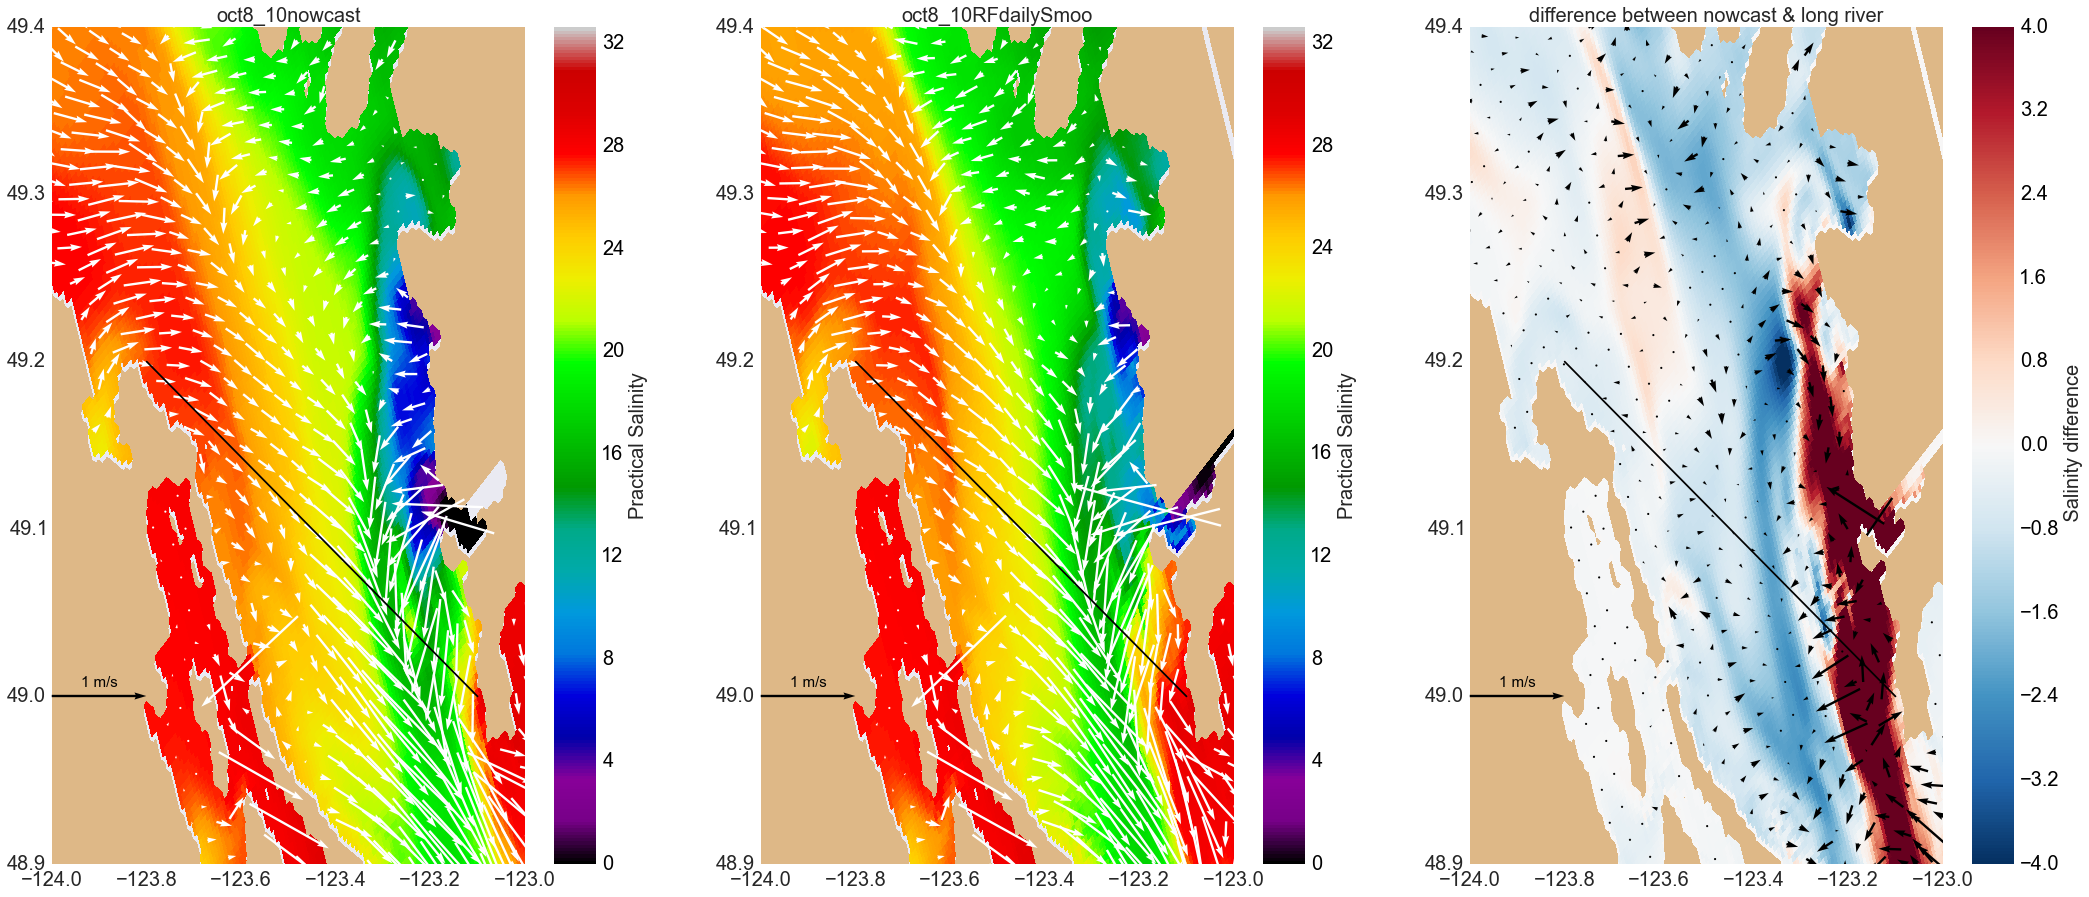

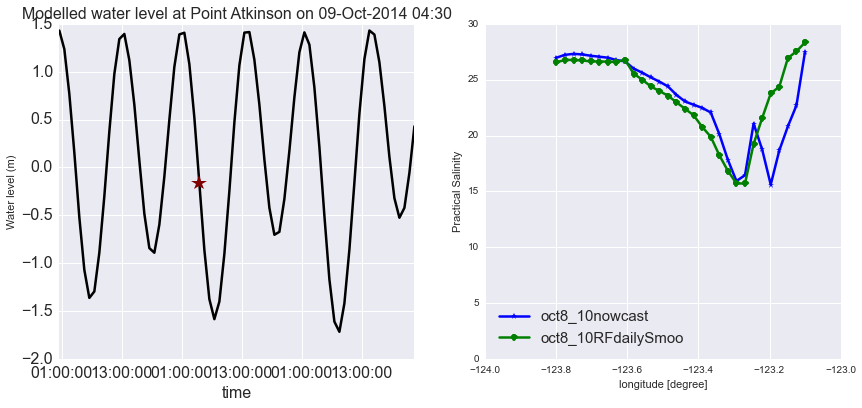

In [6]:
fig = quiver_salinity(28,0)
ssh_plot(runs[1],28,0)

* flood tide

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


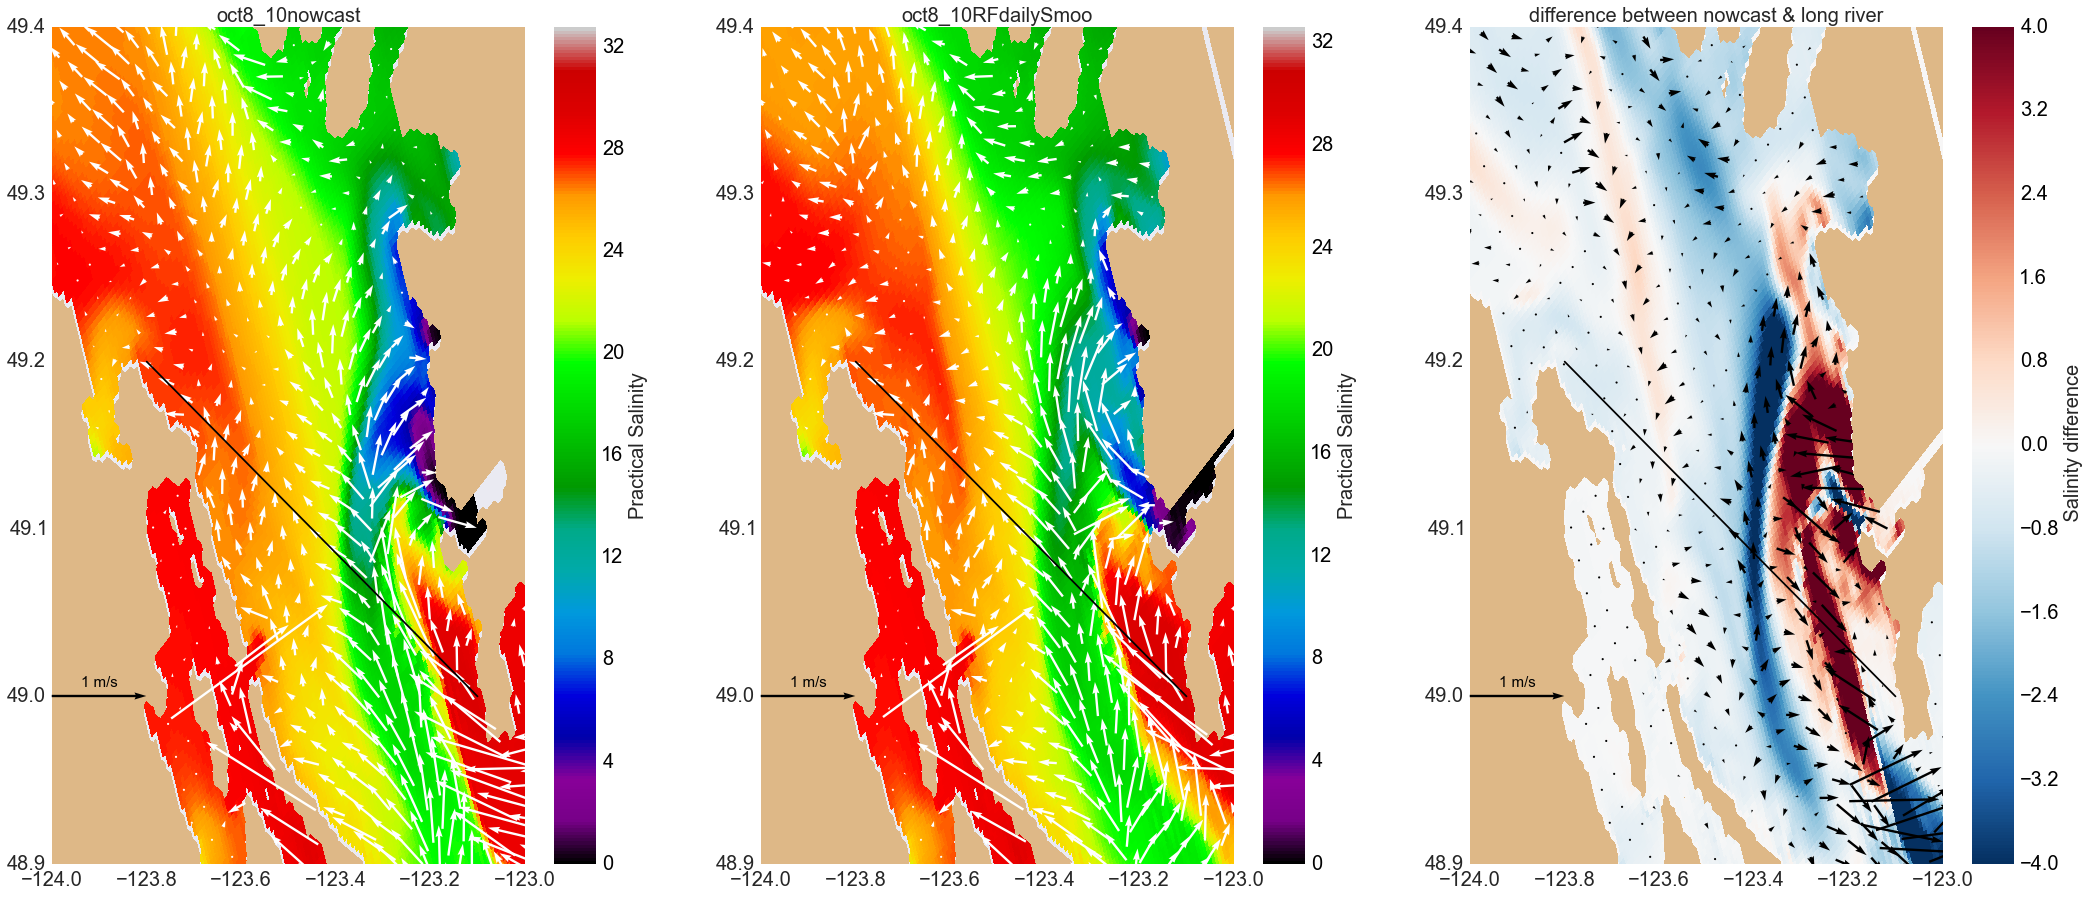

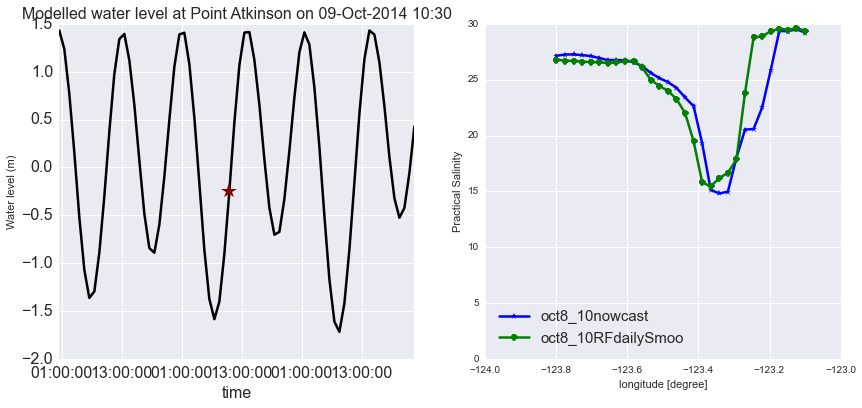

In [7]:
fig = quiver_salinity(34,0)
ssh_plot(runs[1],34,0)

# 1.5m

* ebb tide

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


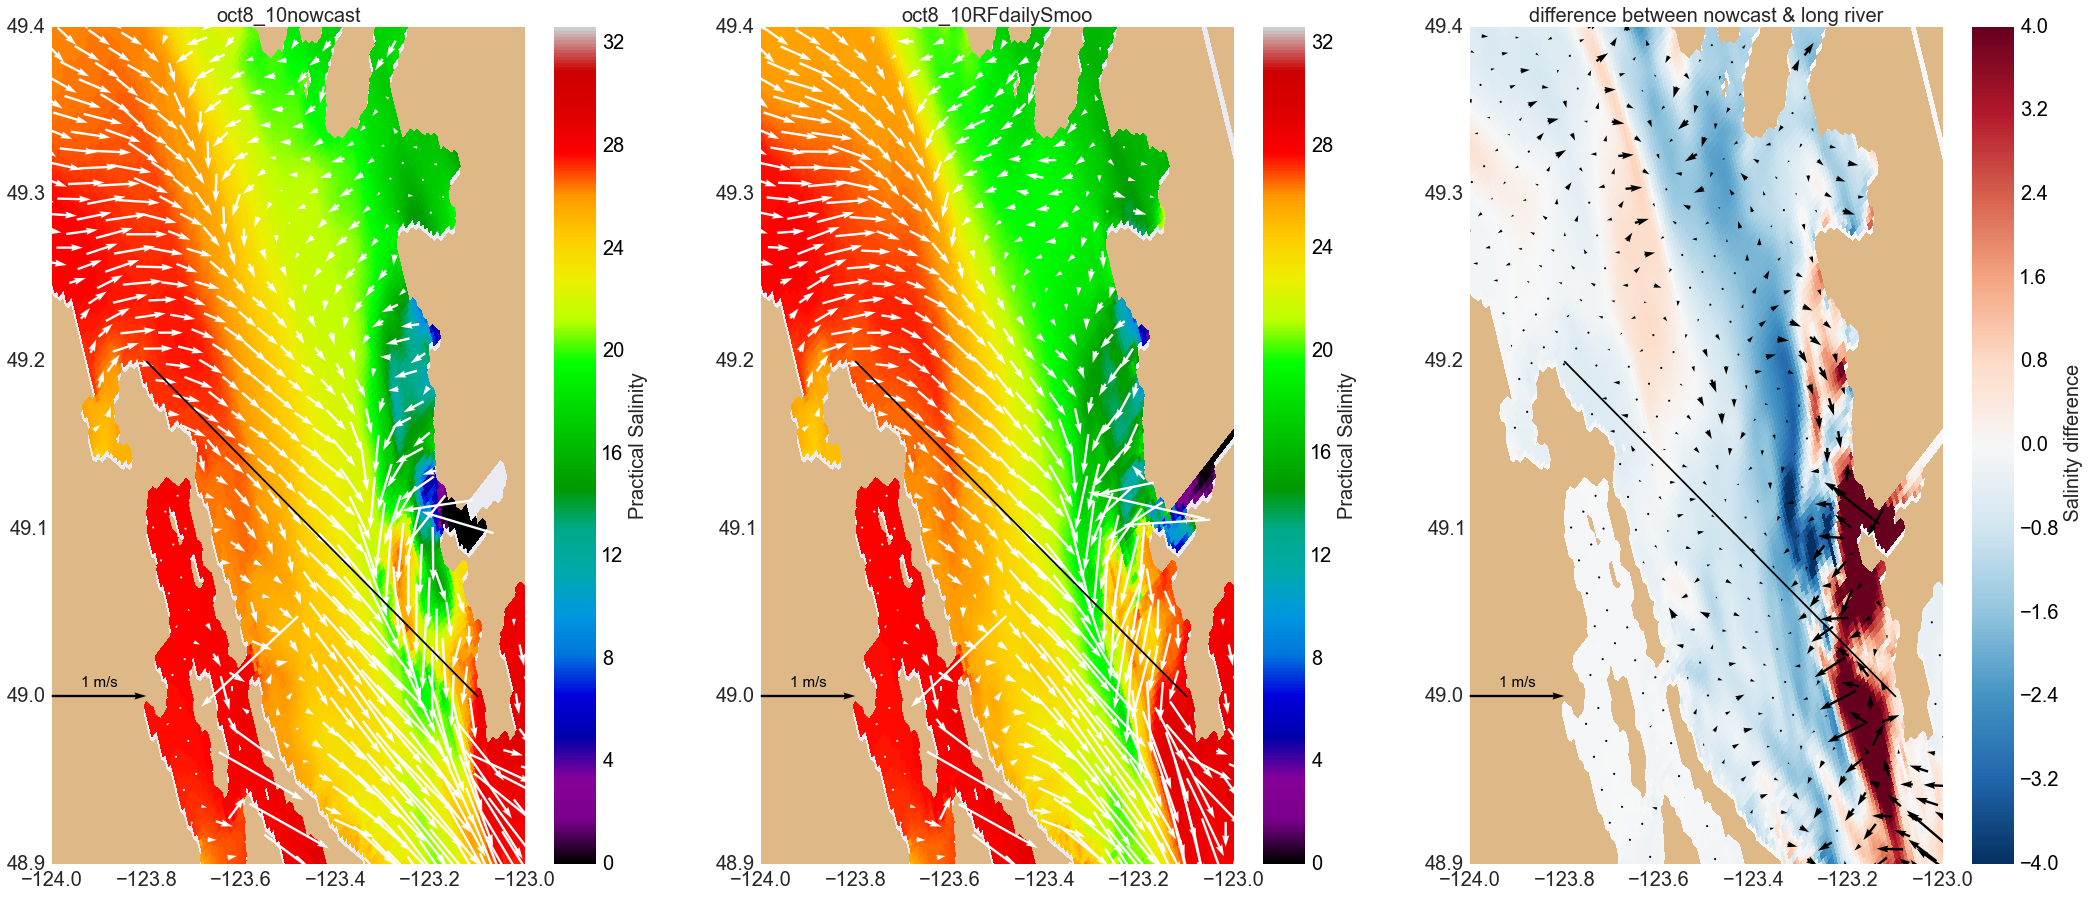

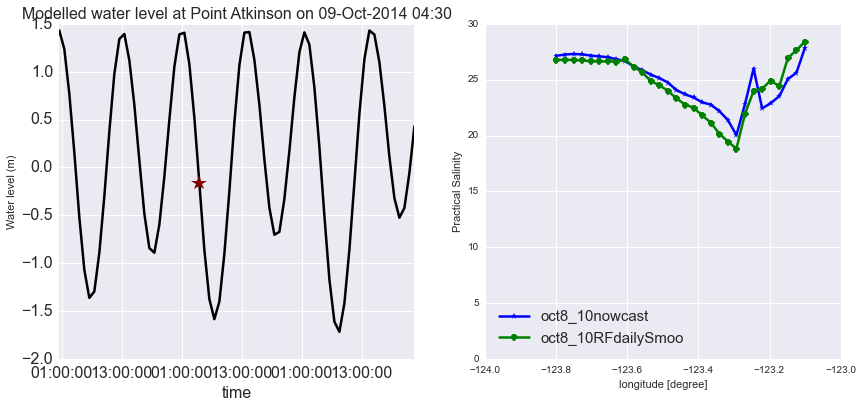

In [8]:
fig = quiver_salinity(28,1)
ssh_plot(runs[1],28,1)

* flood tide

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


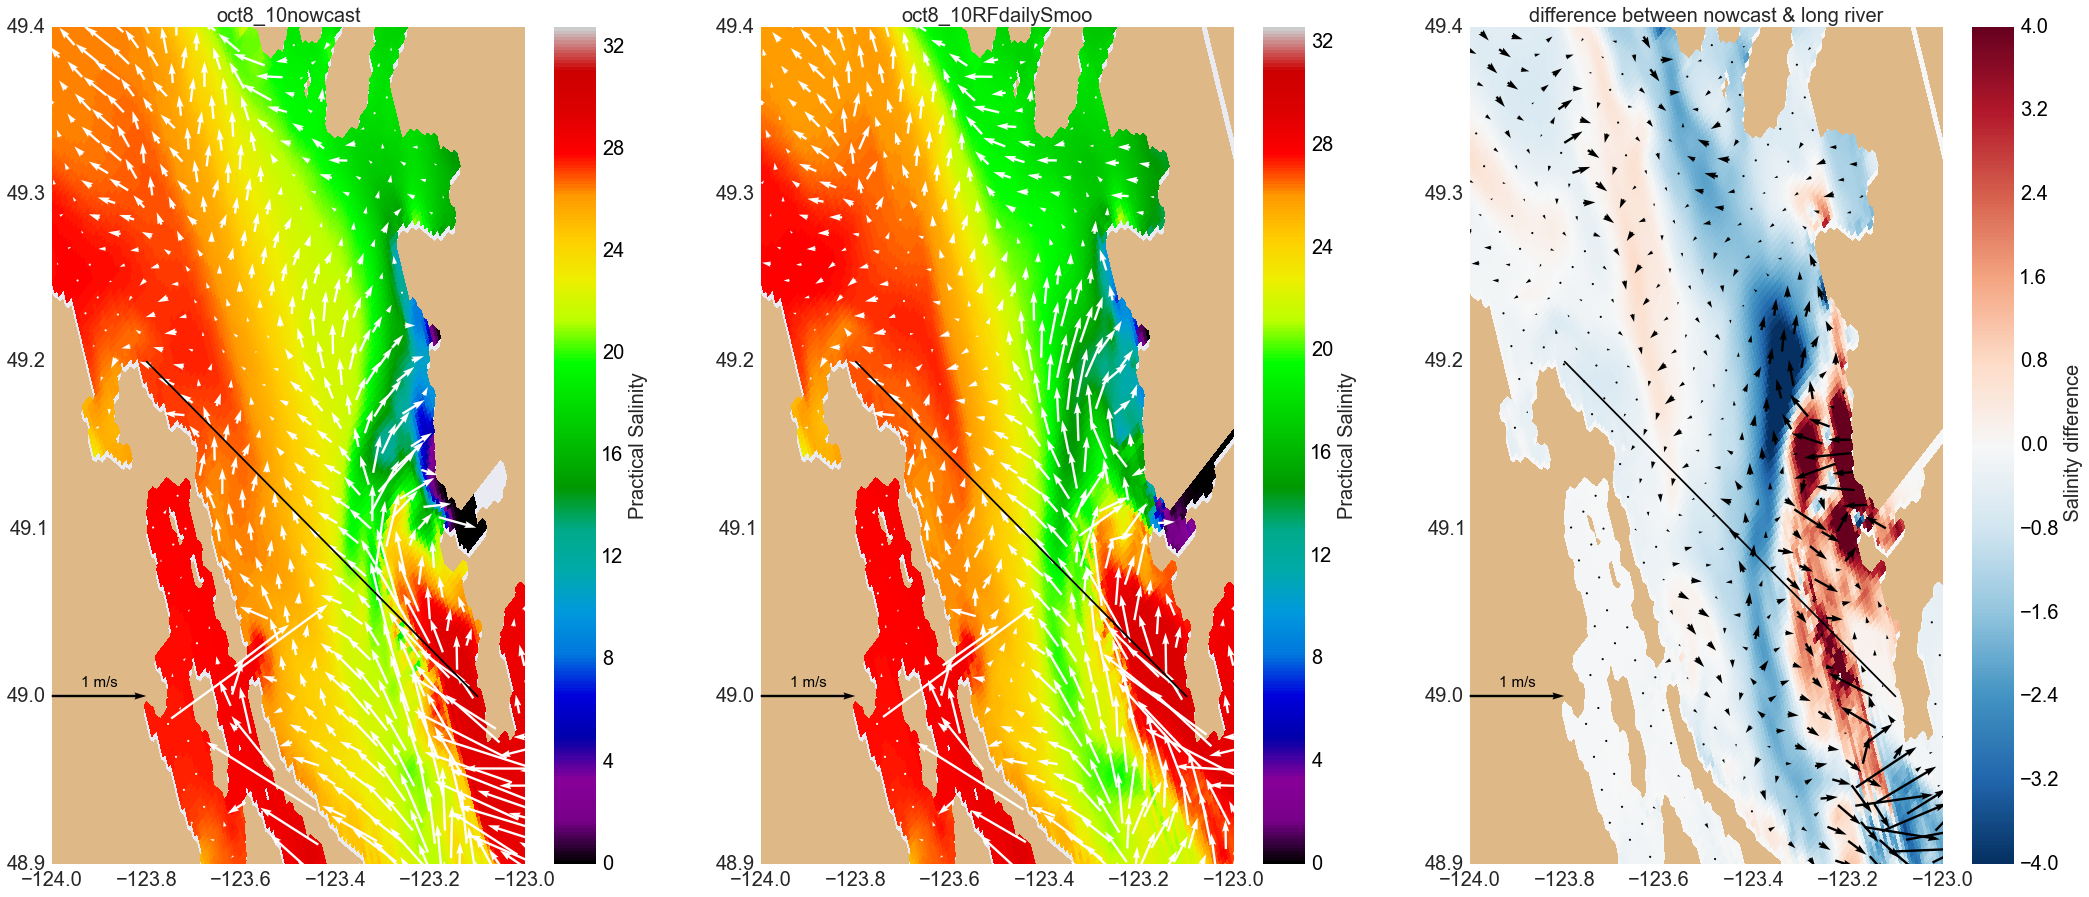

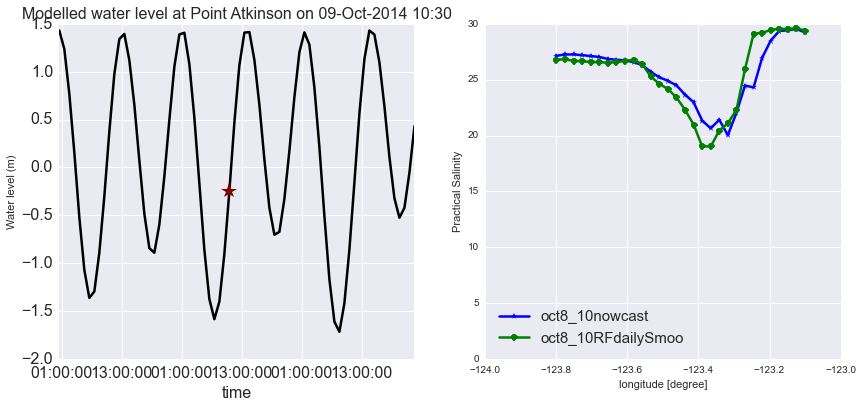

In [9]:
fig = quiver_salinity(34,1)
ssh_plot(runs[1],34,1)

# 2.5 m

* ebb tide

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


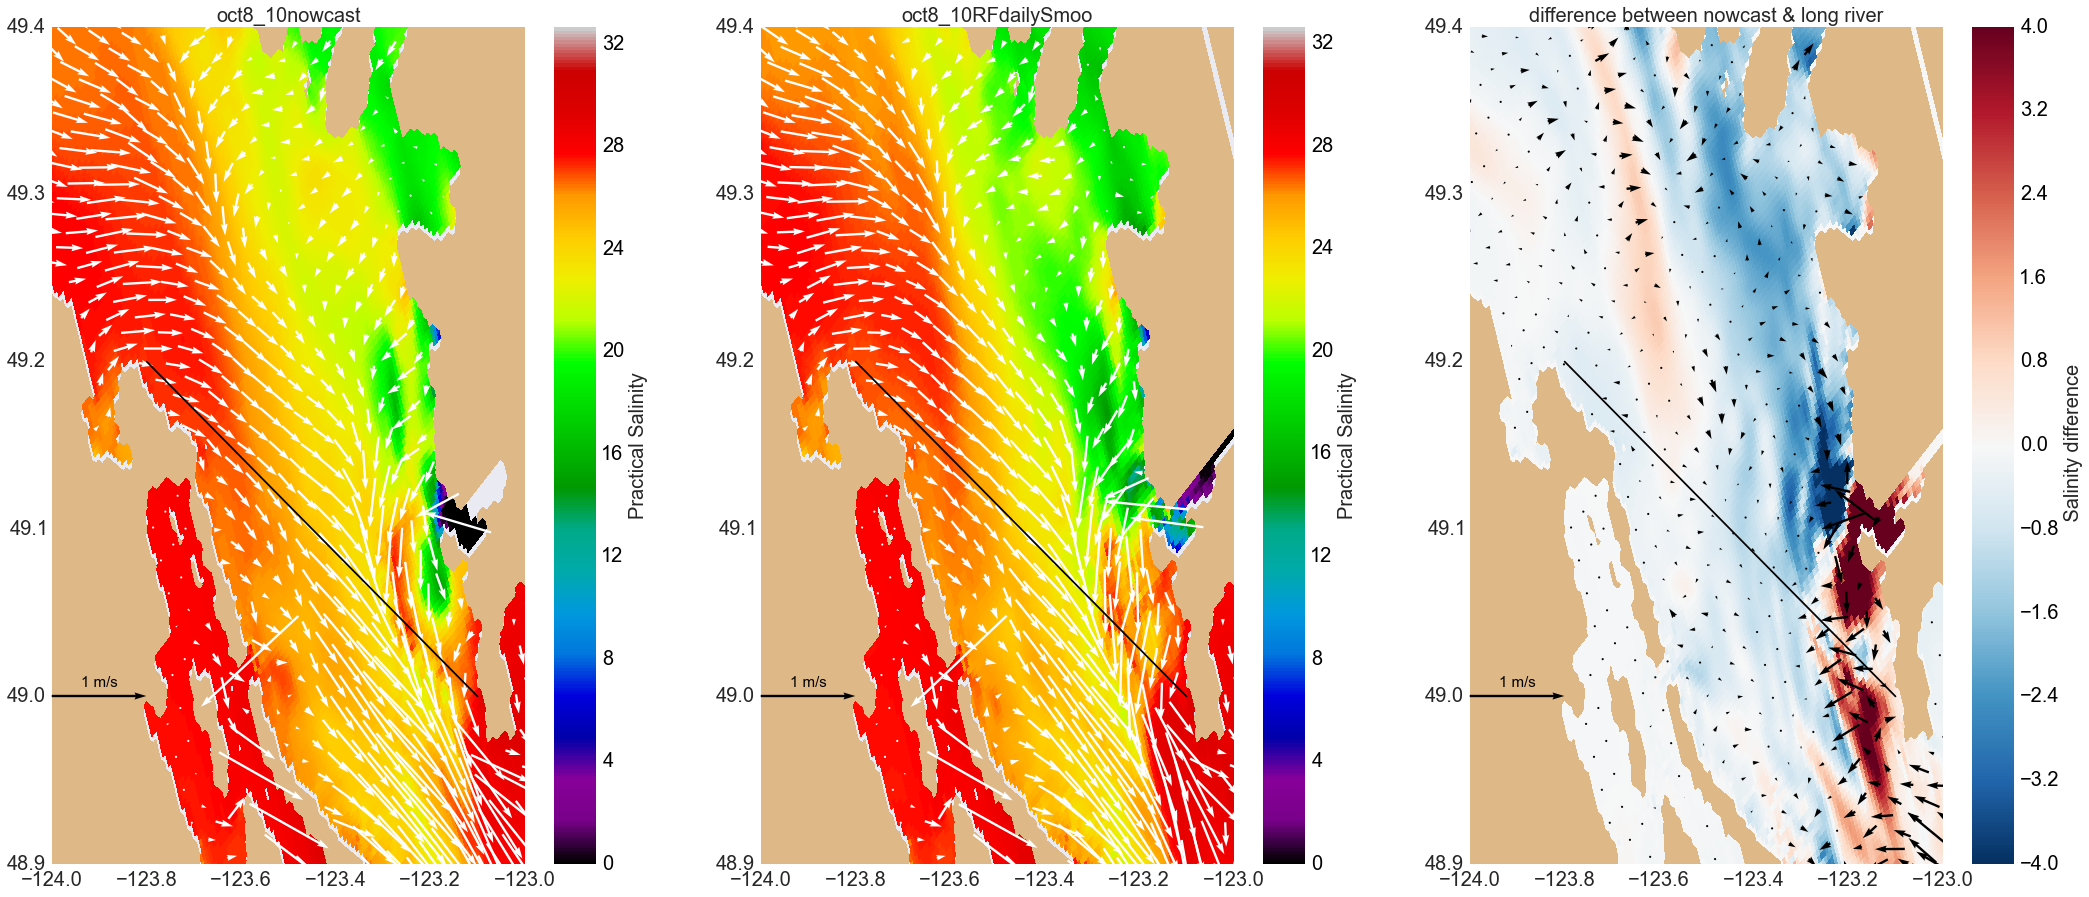

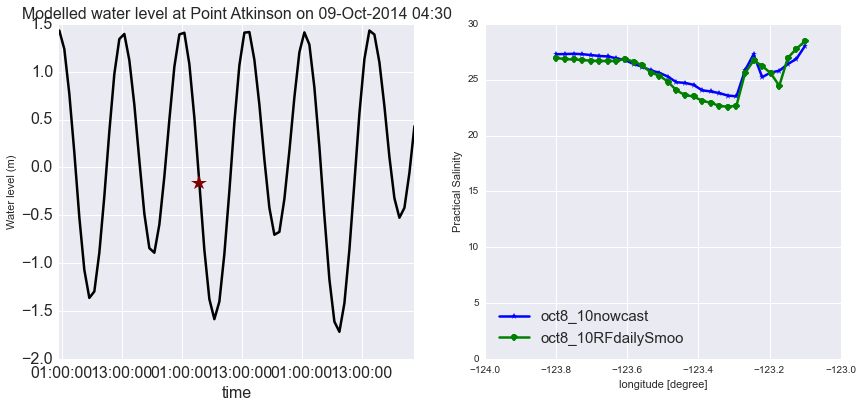

In [10]:
fig = quiver_salinity(28,2)
ssh_plot(runs[1],28,2)

* flood tide

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


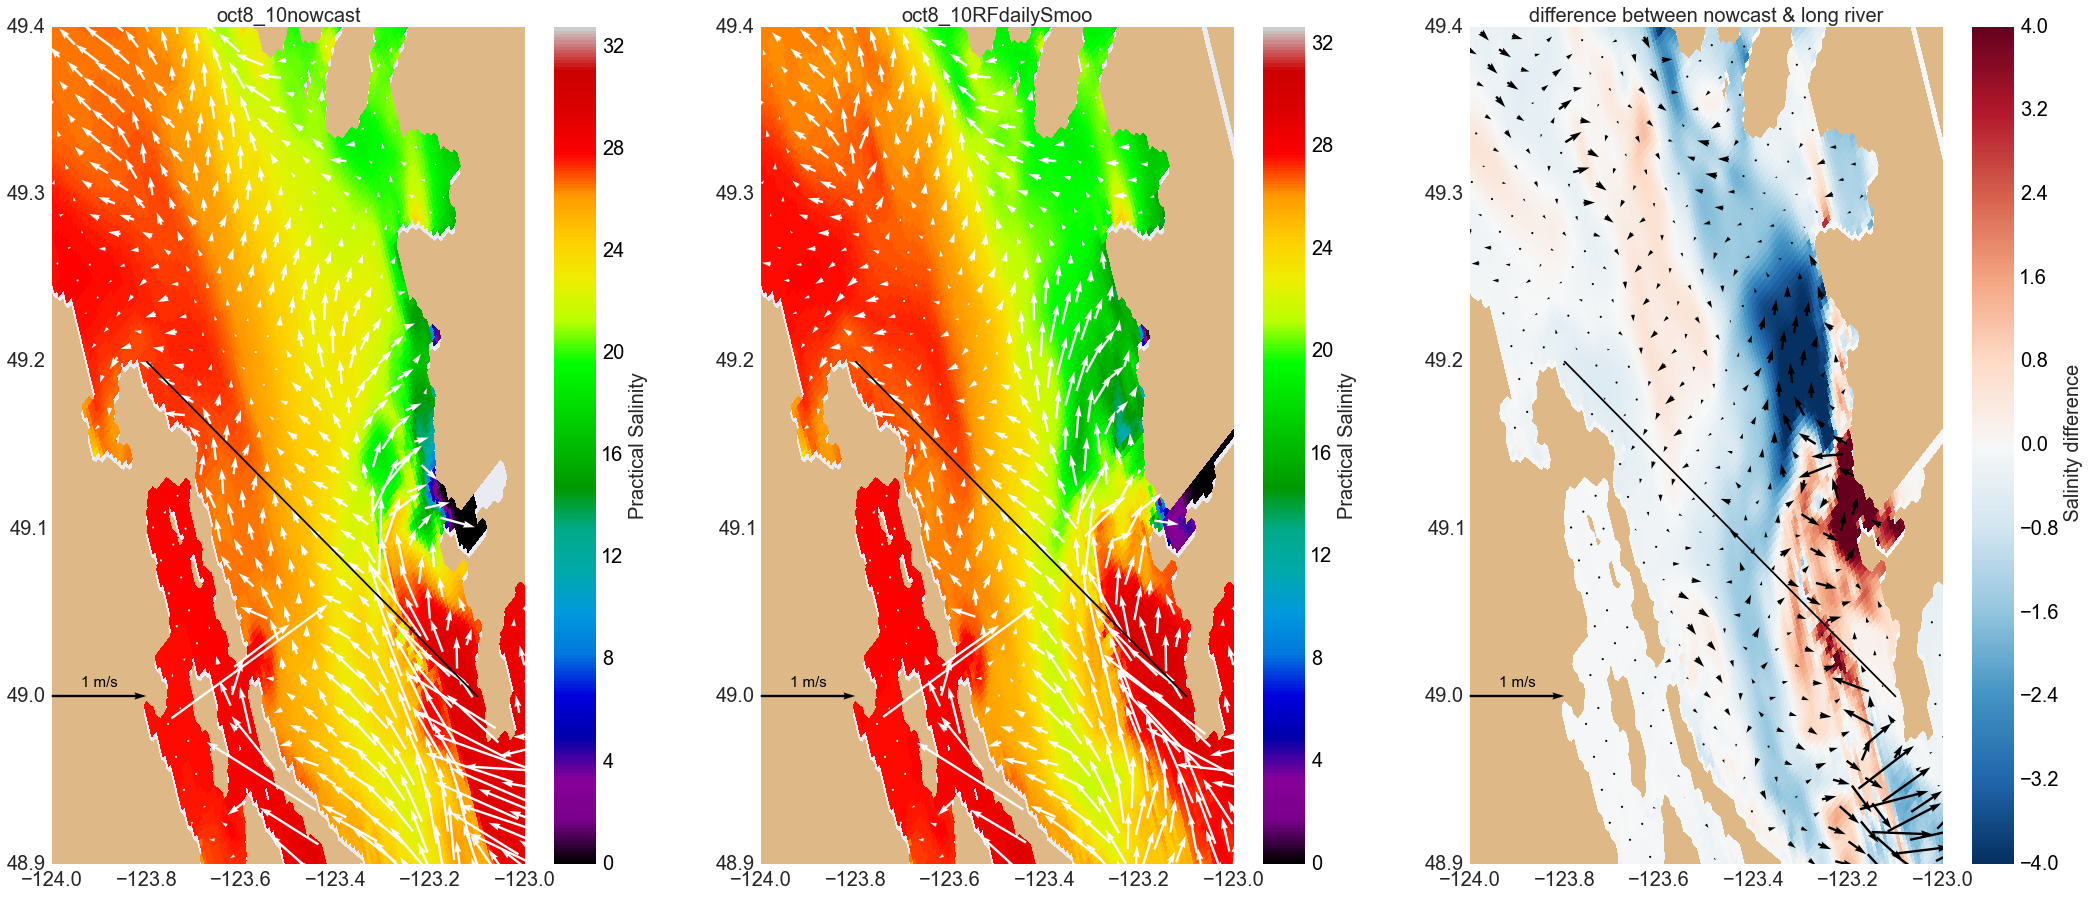

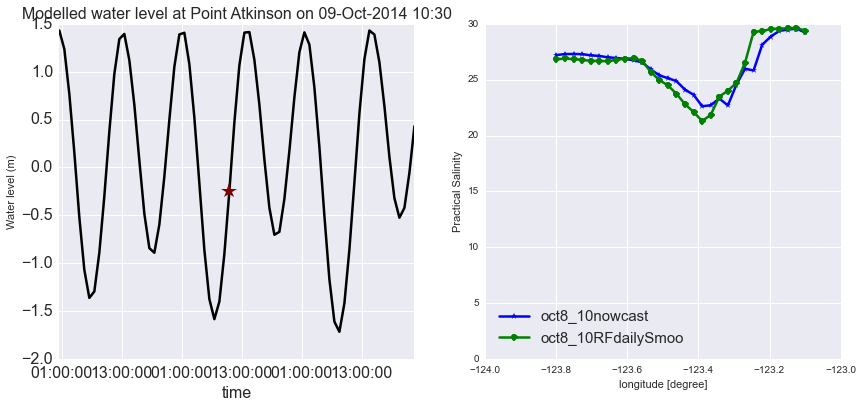

In [11]:
fig = quiver_salinity(34,2)
ssh_plot(runs[1],34,2)

# Check daily file

In [12]:
runs=['oct8_10nowcast','oct8_10RFdailySmoo']
base='/data/jieliu/MEOPAR/river-treatment'
depths={};sals={}; ssh = {};Us={}; Vs={}
for run in runs:
    path = os.path.join(base,'{}/SalishSea_1d_20141008_20141010_grid_T.nc'.format(run))
    f = nc.Dataset(path,'r');
    sals[run]=f.variables['vosaline']
    ssh[run] = f.variables['sossheig']
    depths[run] = f.variables['deptht'] 
    T_lat = f.variables['nav_lat']
    T_lon = f.variables['nav_lon']
    timesteps = f.variables['time_counter']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20141008_20141010_grid_U.nc'.format(run))
    f = nc.Dataset(path,'r');
    Us[run]=f.variables['vozocrtx']
    #Loading data on the ugrid
    path = os.path.join(base,'{}/SalishSea_1d_20141008_20141010_grid_V.nc'.format(run))
    f = nc.Dataset(path,'r');
    Vs[run]=f.variables['vomecrty']
## for time t
path = os.path.join(base,'{}/SalishSea_1d_20141008_20141010_grid_T.nc'.format(runs[0]))
f = nc.Dataset(path,'r');
t_t = nc_tools.timestamp(f, np.arange(len(timesteps)))
for ind in range(len(t_t)):
    t_t[ind] = t_t[ind].datetime
tt = np.array(t_t)   

* surface layer

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


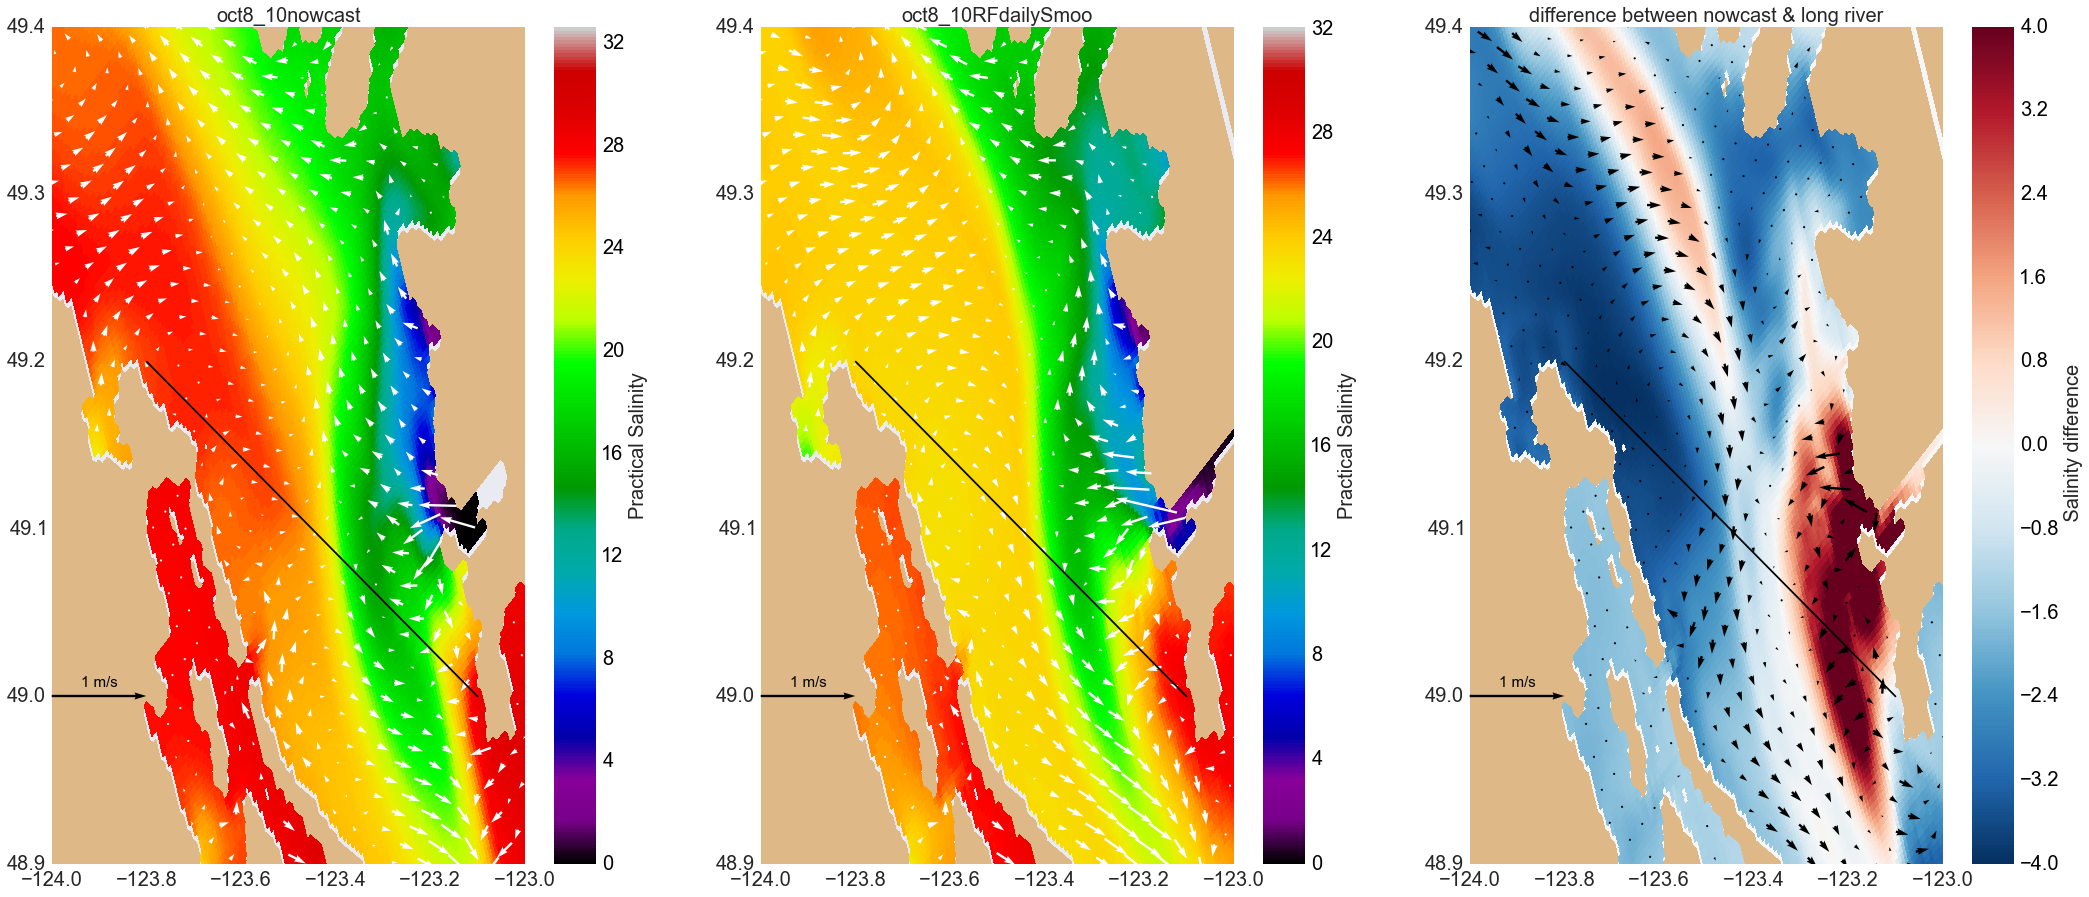

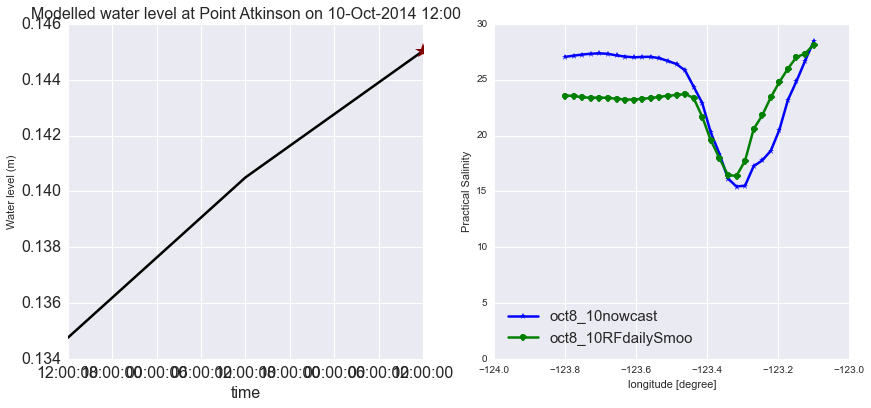

In [13]:
fig = quiver_salinity(-1,0)
ssh_plot(runs[1],-1,0)

* Ok, even in hourly result, the mouth region of long river case is still saltier than short river one. Similar behavior with 3.6 which exclude the guess of different behaviors of 3.6 and 3.4. However, the question still exists that what caused this saltier layer at surface with long river?? Vertical mixing or freshwater difference at the mouth? Need to consult Susan about the calculation of freshwater flux at the mouth and argue if this method works for separate these two forming mechanisms... 